# Optimize cfc code so amino acids occuring often are as different as possible

In [1]:
%config InlineBackend.figure_format='retina'
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.spatial.distance import hamming
import pandas as pd

In [2]:
palmdb = "/home/laura/projects/virus-watch-data/virus_ref/uniques.fa"

In [3]:
!seqkit stats $palmdb

file                                                        format  type     num_seqs     sum_len  min_len  avg_len  max_len
/home/laura/projects/virus-watch-data/virus_ref/uniques.fa  FASTA   Protein   296,623  32,514,833       50    109.6      250


In [4]:
aa_list = ["F", "L", "I", "M", "V", "S", "P", "T", "A", "Y", "H", "Q", "N", "K", "D", "E", "C", "W", "R", "G", "X", "B", "J", "Z"]

aa_counts = []
for aa in aa_list:
    aa_count = !grep -v ">" $palmdb | grep -E -o $aa | wc -l
    print(aa_count[0])
    aa_counts.append(aa_count[0])

1669914
3331366
2014865
1059781
2186067
2490977
1004852
1822582
2191110
1368009
721676
899653
1394019
1316664
2326511
1436822
765515
578490
1640084
2257653
38069
88
49
17


In [5]:
np.array(aa_counts).astype(int).sum()

32514833

In [6]:
df = pd.DataFrame()
df["aa"] = aa_list
df["aa_count"] =  np.array(aa_counts).astype(int)
df = df.sort_values("aa_count", ascending=False)

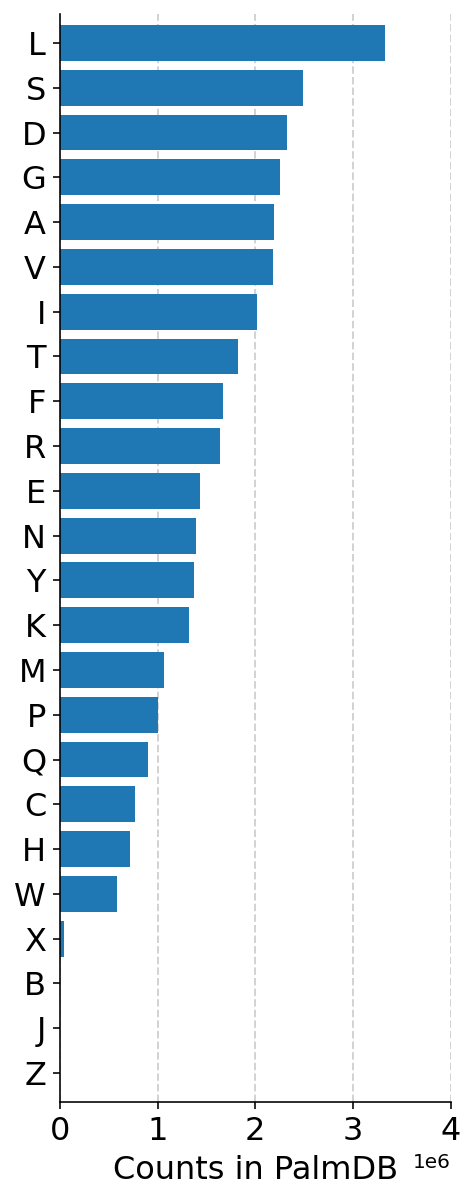

In [27]:
fig, ax = plt.subplots(figsize=(3.5, 10))
fontsize = 16

ax.barh(df["aa"].values, df["aa_count"].values)

ax.set_xlabel("Counts in PalmDB", fontsize=fontsize)

ax.tick_params(axis="both", labelsize=fontsize)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)
ax.yaxis.grid(False)
ax.spines[['right', 'top']].set_visible(False)
ax.margins(y=0.01)

ax.set_xlim(right=4*10**6)
plt.gca().invert_yaxis()

# plt.tight_layout()
plt.savefig(f"figures/palmdb_char_counts.png", dpi=300, bbox_inches="tight")

fig.show()

### Plot Hamming distance between amino acids after reverse translation into comma free code:

In [10]:
# comma-free code AA dictionary
cfcode = {
    "F": "ACC",
    "L": "ACA",
    "I": "ATA",
    "M": "ATC",
    "V": "ATT",
    "S": "CTA",
    "P": "CTC",
    "T": "CTT",
    "A": "AGA",
    "Y": "AGC",
    "H": "AGT",
    "Q": "AGG",
    "N": "CGA", 
    "K": "CGC",
    "D": "CGT",
    "E": "CGG",
    "C": "TGA",
    "W": "TGC",
    "R": "TGT",
    "G": "TGG",
    "X": "NNN",  # Amino acid not known
    "B": "CGT",  # Represents either N or D - will translate as D here (N is only off by one base)
    "J": "ACA",  # Represents either L or I - will translate as L here (I is only off by one base)
    "Z": "CGG"   # Represents either E or Q - will translate as E here (Q is only off by one base)
}

In [11]:
n = len(df["aa"].values)
hamming_mtx = np.zeros((n,n))

for x_idx, aa1 in enumerate(df["aa"].values):
    for y_idx, aa2 in enumerate(df["aa"].values):
        hamming_mtx[x_idx, y_idx] = hamming(list(cfcode[aa1]), list(cfcode[aa2])) * 3

/tmp/ipykernel_303610/1197085057.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = matplotlib.cm.get_cmap("Reds_r")


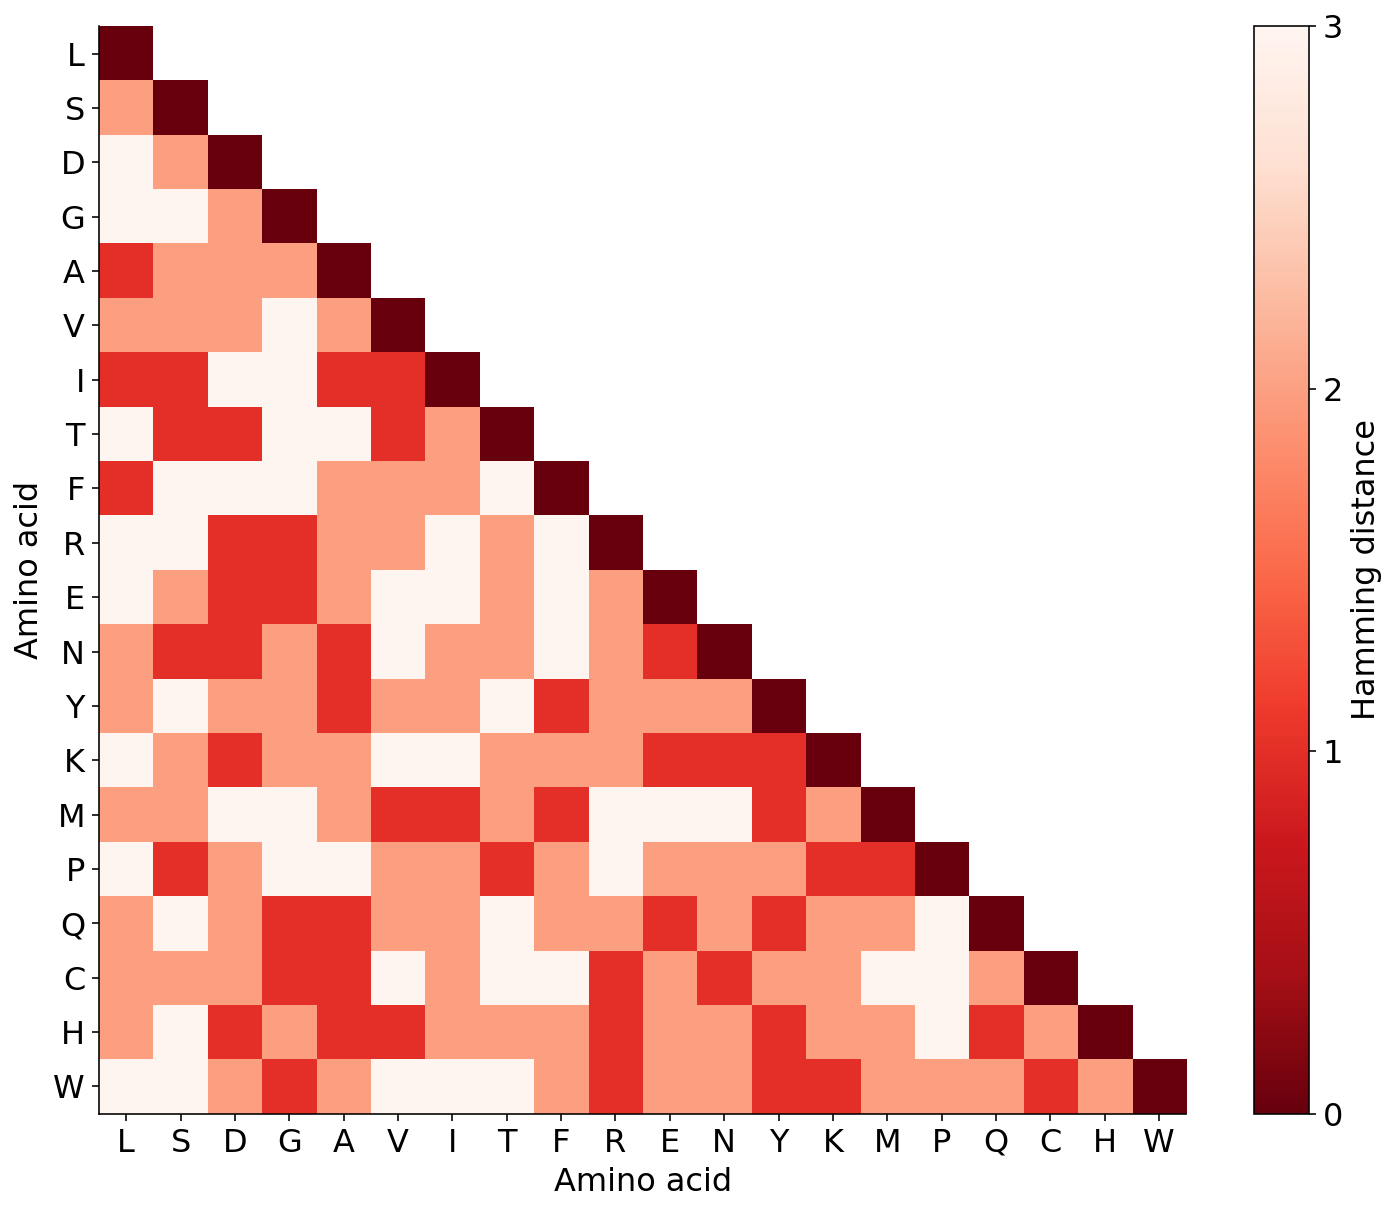

In [12]:
fig, ax = plt.subplots(figsize=(12.2, 10))
fontsize = 16

mask = np.tri(hamming_mtx.shape[0], k=-1)
data = np.ma.array(hamming_mtx, mask=mask)

cmap_reversed = matplotlib.cm.get_cmap("Reds_r")
im = ax.imshow(data.T[:-4, :-4], cmap=cmap_reversed)
cbar = fig.colorbar(im, ax=ax, ticks=[0, 1, 2 ,3])
cbar.set_label("Hamming distance", fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

ax.spines[['right', 'top']].set_visible(False)

ax.set_xticks(np.arange(len(df["aa"].values)-4))
ax.set_yticks(np.arange(len(df["aa"].values)-4))
ax.set_xticklabels(df["aa"].values[:-4])
ax.set_yticklabels(df["aa"].values[:-4])

ax.set_ylabel("Amino acid", fontsize=fontsize)
ax.set_xlabel("Amino acid", fontsize=fontsize)

ax.tick_params(axis="both", labelsize=fontsize)

plt.savefig(f"figures/cfc_hamming_dists.png", dpi=300, bbox_inches="tight", transparent=True)

fig.show()

### Generate new optimal code where amino acids that occur more often have a larger Hamming distance:

ChatGPT asnwer to prompts:  
"Give me 20 three-letter words using only the following letters: "A", "T", "G" and "C", such that the Hamming distances between the words are maximized"  
"Using the code from your first answer, sort the words such that those that are most different from all others are listed first"  
Followed by some manual switching of codons to further optimize the code and account for ambigious annotations.

In [13]:
# ChatGPT code
cfcode_gpt = {
    'L': "GGG",
    'S': "TTC",
    'D': "CTA",
    'G': "GCT",
    'A': "TCG",
    'V': "AGC",
    'I': "GTG",
    'T': "GAC",
    'F': "TAG",
    'R': "ATG",
    'E': "CGA",
    'N': "GTA",
    'Y': "TAC",
    'K': "CAT",
    'M': "CAG",
    'P': "AGT",
    'Q': "TGA",
    'C': "CGT",
    'H': "GCA",
    'W': "ACT",
    "X": "NNN",  # Amino acid not known
    "B": "CTA",  # Represents either N or D - will translate as D here (N is only off by one base)
    "J": "GGG",  # Represents either L or I - will translate as L here (I is only off by one base)
    "Z": "CGA"   # Represents either E or Q - will translate as E here (Q is only off by one base)
}

In [14]:
n = len(df["aa"].values)
hamming_mtx = np.zeros((n,n))

for x_idx, aa1 in enumerate(df["aa"].values):
    for y_idx, aa2 in enumerate(df["aa"].values):
        hamming_mtx[x_idx, y_idx] = hamming(list(cfcode_gpt[aa1]), list(cfcode_gpt[aa2])) * 3

/tmp/ipykernel_303610/1786649198.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = matplotlib.cm.get_cmap("Reds_r")


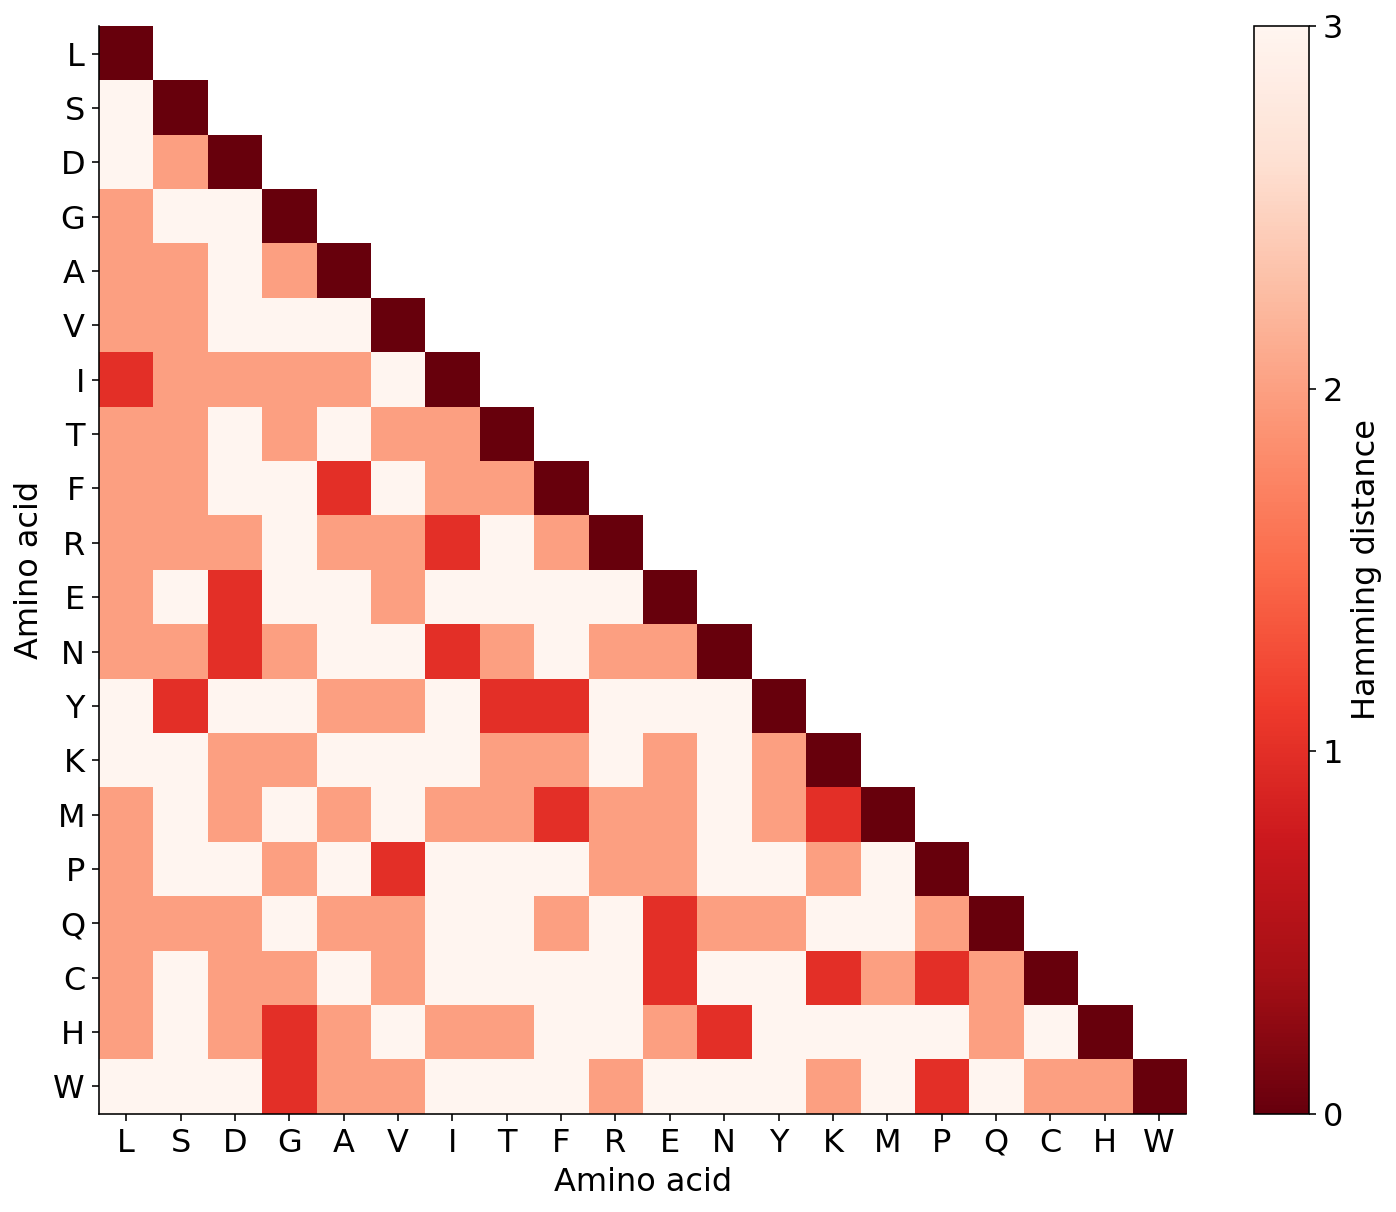

In [15]:
fig, ax = plt.subplots(figsize=(12.2, 10))
fontsize = 16

mask = np.tri(hamming_mtx.shape[0], k=-1)
data = np.ma.array(hamming_mtx, mask=mask)

cmap_reversed = matplotlib.cm.get_cmap("Reds_r")
im = ax.imshow(data.T[:-4, :-4], cmap=cmap_reversed)
cbar = fig.colorbar(im, ax=ax, ticks=[0, 1, 2 ,3])
cbar.set_label("Hamming distance", fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

ax.spines[["right", "top"]].set_visible(False)

ax.set_xticks(np.arange(len(df["aa"].values)-4))
ax.set_yticks(np.arange(len(df["aa"].values)-4))
ax.set_xticklabels(df["aa"].values[:-4])
ax.set_yticklabels(df["aa"].values[:-4])

ax.tick_params(axis="both", labelsize=fontsize)

ax.set_ylabel("Amino acid", fontsize=fontsize)
ax.set_xlabel("Amino acid", fontsize=fontsize)

plt.savefig(f"figures/gpt_hamming_dists.png", dpi=300, bbox_inches="tight", transparent=True)

fig.show()

Manually:

In [31]:
# %%time
# alphabet = "ACGT"
# hamming_threshold = 2

# words_found = 1
# wordlist = []
# while len(wordlist) < 20:
#     new_word = random.choice(alphabet) + random.choice(alphabet) + random.choice(alphabet)
#     too_close = False
    
#     for word in wordlist:
#         if hamming(list(word), list(new_word)) * 3 < hamming_threshold:
#             too_close = True
#             continue
            
#     if not too_close:
#         wordlist.append(new_word)
#         print("Words found: ", words_found)
#         words_found += 1